In [1]:
# QPIE method ( Quantum Probability Image Encoding )

# Importing the libraries
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, BasicAer, transpile, assemble
from qiskit.execute_function import execute
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from PIL import Image
from typing import Dict, List, Tuple
from collections import Counter
from sklearn.metrics import mean_squared_error
import pickle
import json
from itertools import chain
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# GLOBAL VARIABLES
DIM = 28
NUM_QUBITS = 10


###########################
##### Functions #####
###########################

def encode_img(image, register_num):
    ''' encoding of image using QPIE method '''
    img = list(chain(*image))
    pix_val = img

    # normalize
    pix_norm = np.linalg.norm(pix_val)
    pix_val = np.array(pix_val)
    arr_norm = pix_val/pix_norm
    arr_norm = arr_norm.tolist()

    # Encode onto the quantum register
    qc = QuantumCircuit(register_num)
    # test = arr_norm.append(np.zeros(2**10-arr_norm.shape))
    test = arr_norm + np.zeros(2**register_num-DIM**2).tolist()
    qc.initialize(test)
    return qc


def encode(image):
    ''' final wrapper function (for submission) '''
    return encode_img(255*255*image, register_num=NUM_QUBITS)


def decode_img(histogram):
    ''' decoding (written by prathu) '''
    pixelnums = list(range(DIM**2))
    for pix in pixelnums:
        if pix not in histogram.keys():
            # grayscale pixel value is 0
            histogram.update({pix: 0})

    histnew = dict(sorted(histogram.items()))

    histdata = []
    # for i in enumerate(histnew):
    for i in range(len(histnew)):
        histdata.append(histnew[i])
    histdata = np.array(histdata)
    histarr = np.reshape(histdata, (DIM, DIM))

    return histarr


def decode(histogram):
    ''' final wrapper function (for submission) '''
    return decode_img(histogram)


################
# Helpers
################


def simulate(circuit: QuantumCircuit) -> Dict:
    """Simulate circuit given state vector"""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector(circuit)

    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population

    return histogram


def histogram_to_cat(histogram):
    assert abs(sum(histogram.values()) - 1) < 1e-8
    positive = 0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1] == '0':
            positive += histogram[key]

    return positive


def image_mse(img1, img2):
    return mean_squared_error(img1, img2)


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """ finds num of gate operations with each num of qubits """
    return Counter([len(gate[1]) for gate in circuit.data])

In [2]:
# Testing Encoding/Decoding - Showing image before and after (original --> decoded from original)
images = np.load('../data/images.npy')
labels = np.load('../data/labels.npy')
testimage = images[0]
#print(labels)
# print(images[0])

# test part1
def run_part1(image):
    circuit = encode(image)
    histogram = simulate(circuit)
    image_reconstructed = decode(histogram)
    return circuit, image_reconstructed

Original image - Before


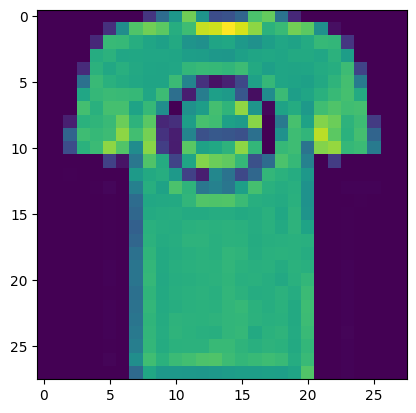

In [3]:
print("Original image - Before")
plt.imshow(testimage)

In [ ]:
print("Reconstructed image - After")
print("Encoding Technique : QPIE , Decoding Technique : Classical")
start = time.process_time()
circuit,image_reconstructed = run_part1(testimage)
plt.imshow(image_reconstructed)
print("Elapsed Time:",time.process_time() - start,"Seconds")

Reconstructed image - After
Encoding Technique : QPIE , Decoding Technique : Classical


In [ ]:
###########################
##### Main #####
###########################

# load data
images = np.load('../data/images.npy')
labels = np.load('../data/labels.npy')


# test part1
def run_part1(image):
    circuit = encode(image)
    histogram = simulate(circuit)
    image_reconstructed = decode(histogram)
    return circuit, image_reconstructed


start = 200
stop = 201
images = images[start:stop]
length = len(images)
mse = 0
gatecount = 0

print("Encoding/Decoding Start")
for image in tqdm(images):
    # encode
    circuit, image_reconstructed = run_part1(image)
    # count num of 2qubit gates
    gatecount += count_gates(circuit)[2]
    # calculate mse
    mse += image_mse(image, image_reconstructed)
    

# fidelity of reconstruction
f = 1-mse/length
gatecount = gatecount/length

# score
score = f*(0.999**gatecount)

print('fidelity: ', f)
print('gatecount: ', gatecount)
print('score: ', score)

# for image in images:
#     while start < stop:
#         circuit = encode_img(255*255*image, 10)
#         histogram = simulate(circuit)
#         print(histogram)
#     start += 1